In [1]:
# We perfrom classification of customer as satified and disatisfied using Random forest and Logistic regression, while
# compare their performance.

In [176]:
library(ggplot2)
library(dplyr)
library(glmnet)
library(plotmo)
library(caret)
library(randomForest)
library(caTools)# for data sampling
library(car) # for vif // checking for multicollinearity
library(yardstick)
library(ggplot2)
library(ROCR)

In [177]:
# 1) Data Extraction

In [253]:
df = read.csv("C:\\Users\\hp\\Downloads\\fligh_passenger_satisfaction\\train.csv")
df_1 = read.csv("C:\\Users\\hp\\Downloads\\fligh_passenger_satisfaction\\test.csv")

In [254]:
df = rbind(df,df_1)

In [255]:
df

X,id,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,⋯,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,⋯,5,4,3,4,4,5,5,25,18,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,⋯,1,1,5,3,1,4,1,1,6,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,⋯,5,4,3,4,4,4,5,0,0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,⋯,2,2,5,3,1,4,2,11,9,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,⋯,3,3,4,4,3,3,3,0,0,satisfied
5,111157,Female,Loyal Customer,26,Personal Travel,Eco,1180,3,4,⋯,1,3,4,4,4,4,1,0,0,neutral or dissatisfied
6,82113,Male,Loyal Customer,47,Personal Travel,Eco,1276,2,4,⋯,2,3,3,4,3,5,2,9,23,neutral or dissatisfied
7,96462,Female,Loyal Customer,52,Business travel,Business,2035,4,3,⋯,5,5,5,5,4,5,4,4,0,satisfied
8,79485,Female,Loyal Customer,41,Business travel,Business,853,1,2,⋯,1,1,2,1,4,1,2,0,0,neutral or dissatisfied


In [181]:
df = subset(df, select = -c(X,id))

In [183]:
x <- table(df$satisfaction)

In [184]:
# To understand the distribution of satisfied and disatisfied customers in different columns we plot three of categorcial
# columns and gain insights as

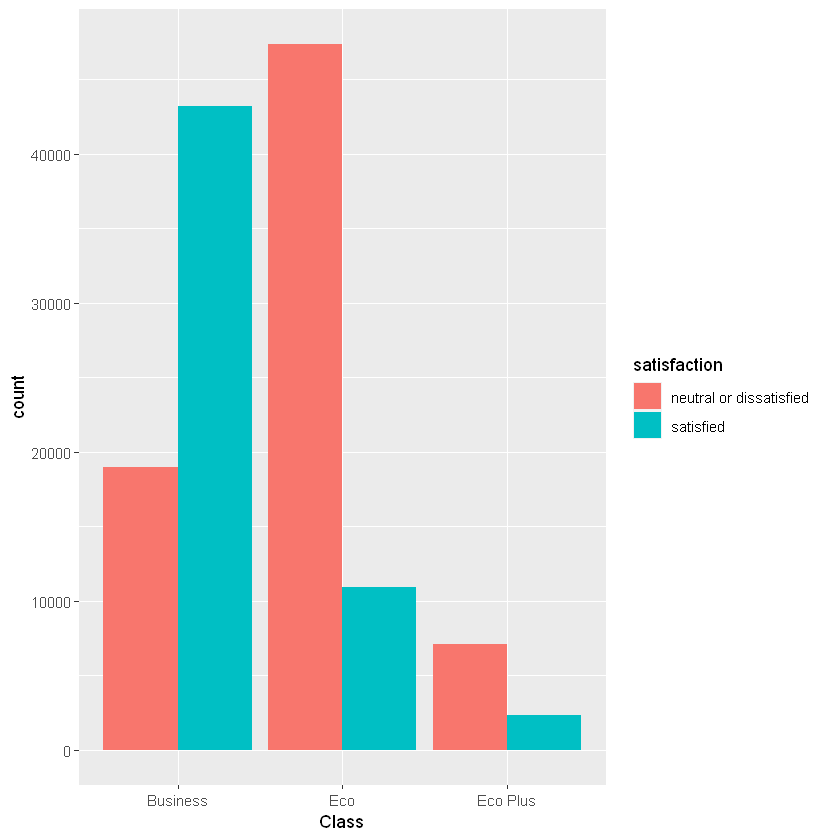

In [185]:
ggplot(data = df, aes(x = Class, fill = satisfaction)) +
    geom_bar(position = "dodge")

In [60]:
#As we can see the ticket class has enough influence on customer satisfaction,
#as the presumably known business class has better-curated services than the Economy

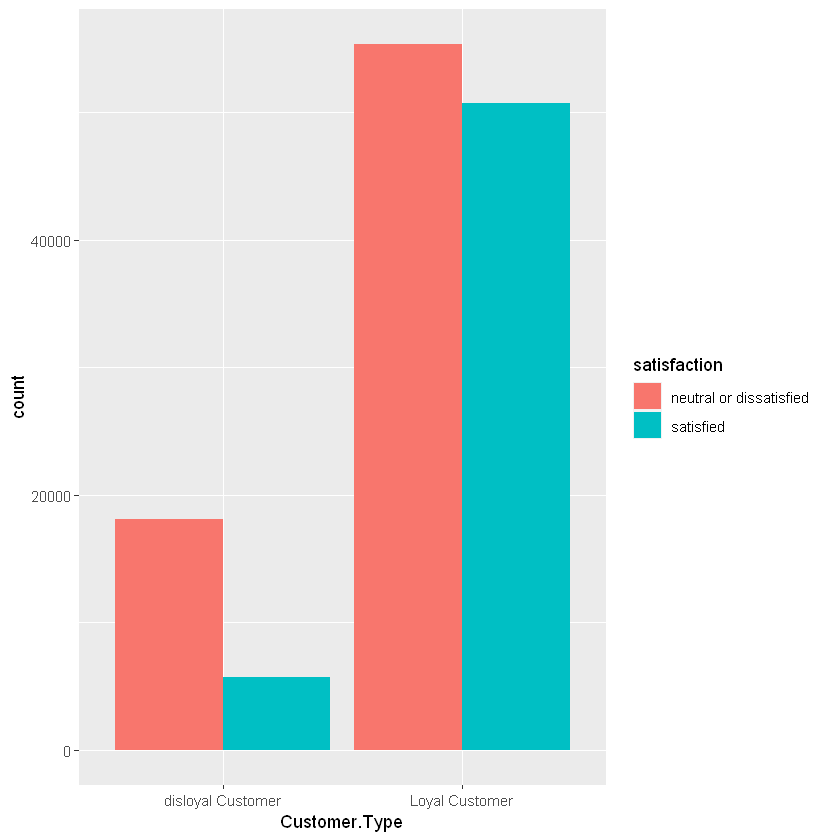

In [186]:
ggplot(data = df, aes(x = Customer.Type, fill = satisfaction)) +
    geom_bar(position = "dodge")

In [187]:
# The disloyal customers are more likely to be disatisfied than the loyal customers

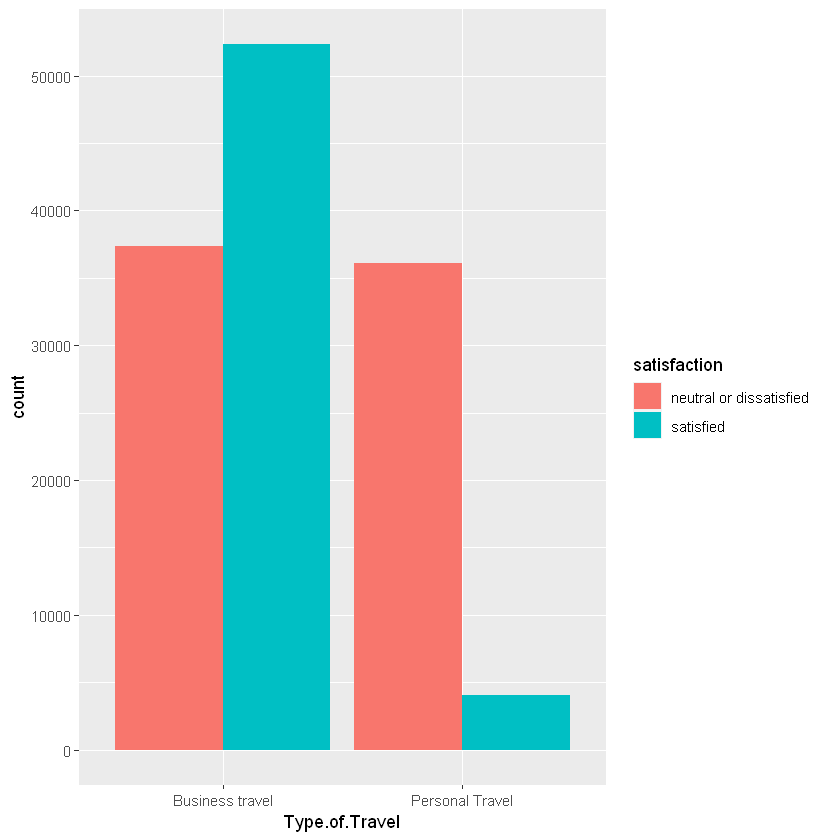

In [188]:
ggplot(data = df, aes(x = Type.of.Travel, fill = satisfaction)) +
    geom_bar(position = "dodge")

In [189]:
# People travelling for Business have very high probability to be satisfied as compared to ones travelling for personal reason

In [190]:
# 2) Data Cleaning and Pre-processing

In [191]:
# In this I will check for missing values, tell the proportion of satisfied and disatisfied after this, encode the response
# column, 

In [194]:
# After checking for missing values we observe that only Arrival.Delay.in.Minutes column has 310 missing values which are
# comparetively less than the total number of observation, thus we replace the values with the mean

In [195]:
df$Arrival.Delay.in.Minutes[is.na(df$Arrival.Delay.in.Minutes)]<-mean(df$Arrival.Delay.in.Minutes,na.rm=TRUE)

In [196]:
summary(df)

    Gender          Customer.Type           Age        Type.of.Travel    
 Length:129880      Length:129880      Min.   : 7.00   Length:129880     
 Class :character   Class :character   1st Qu.:27.00   Class :character  
 Mode  :character   Mode  :character   Median :40.00   Mode  :character  
                                       Mean   :39.43                     
                                       3rd Qu.:51.00                     
                                       Max.   :85.00                     
    Class           Flight.Distance Inflight.wifi.service
 Length:129880      Min.   :  31    Min.   :0.000        
 Class :character   1st Qu.: 414    1st Qu.:2.000        
 Mode  :character   Median : 844    Median :3.000        
                    Mean   :1190    Mean   :2.729        
                    3rd Qu.:1744    3rd Qu.:4.000        
                    Max.   :4983    Max.   :5.000        
 Departure.Arrival.time.convenient Ease.of.Online.booking Gate.location  
 M

In [197]:
# Further we encode the categorical variables to binary values as 1 and 0.

In [198]:
df$Gender <- ifelse(df$Gender == "Male",1,0)

In [199]:
df$Customer.Type <- ifelse(df$Customer.Type == "Loyal Customer",1,0)

In [200]:
df$Type.of.Travel <- ifelse(df$Type.of.Travel == "Personal Travel",1,0)

In [201]:
df$Class <- ifelse(df$Class == "Business",1,0)

In [202]:
#df$satisfaction <- ifelse(df$satisfaction == "satisfied",1,0)

In [203]:
df$satisfaction = as.factor(df$satisfaction)

In [ ]:
y = ifelse(df$satisfaction == "satisfied",1,0)

In [204]:
summary(df)

     Gender       Customer.Type         Age        Type.of.Travel  
 Min.   :0.0000   Min.   :0.0000   Min.   : 7.00   Min.   :0.0000  
 1st Qu.:0.0000   1st Qu.:1.0000   1st Qu.:27.00   1st Qu.:0.0000  
 Median :0.0000   Median :1.0000   Median :40.00   Median :0.0000  
 Mean   :0.4926   Mean   :0.8169   Mean   :39.43   Mean   :0.3094  
 3rd Qu.:1.0000   3rd Qu.:1.0000   3rd Qu.:51.00   3rd Qu.:1.0000  
 Max.   :1.0000   Max.   :1.0000   Max.   :85.00   Max.   :1.0000  
     Class        Flight.Distance Inflight.wifi.service
 Min.   :0.0000   Min.   :  31    Min.   :0.000        
 1st Qu.:0.0000   1st Qu.: 414    1st Qu.:2.000        
 Median :0.0000   Median : 844    Median :3.000        
 Mean   :0.4786   Mean   :1190    Mean   :2.729        
 3rd Qu.:1.0000   3rd Qu.:1744    3rd Qu.:4.000        
 Max.   :1.0000   Max.   :4983    Max.   :5.000        
 Departure.Arrival.time.convenient Ease.of.Online.booking Gate.location  
 Min.   :0.000                     Min.   :0.000          

In [205]:
df

,Gender,Customer.Type,Age,Type.of.Travel,Class,Flight.Distance,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Gate.location,⋯,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Departure.Delay.in.Minutes,Arrival.Delay.in.Minutes,satisfaction
,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
1,1,1,13,1,0,460,3,4,3,1,⋯,5,4,3,4,4,5,5,25,18,neutral or dissatisfied
2,1,0,25,0,1,235,3,2,3,3,⋯,1,1,5,3,1,4,1,1,6,neutral or dissatisfied
3,0,1,26,0,1,1142,2,2,2,2,⋯,5,4,3,4,4,4,5,0,0,satisfied
4,0,1,25,0,1,562,2,5,5,5,⋯,2,2,5,3,1,4,2,11,9,neutral or dissatisfied
5,1,1,61,0,1,214,3,3,3,3,⋯,3,3,4,4,3,3,3,0,0,satisfied
6,0,1,26,1,0,1180,3,4,2,1,⋯,1,3,4,4,4,4,1,0,0,neutral or dissatisfied
7,1,1,47,1,0,1276,2,4,2,3,⋯,2,3,3,4,3,5,2,9,23,neutral or dissatisfied
8,0,1,52,0,1,2035,4,3,4,4,⋯,5,5,5,5,4,5,4,4,0,satisfied
9,0,1,41,0,1,853,1,2,2,2,⋯,1,1,2,1,4,1,2,0,0,neutral or dissatisfied


In [ ]:
# 3) Data Transformation and redundancy check

In [ ]:
# Here I see the frequency of data and check if it is distributed properly and use lasso regression path to identify the
# important features 

In [208]:
x = data.matrix(df[,-c(23)])

In [209]:
cv_model <- cv.glmnet(x, y, alpha = 1)
model = glmnet(x, y, alpha = 1)

In [210]:
cv_model


Call:  cv.glmnet(x = x, y = y, alpha = 1) 

Measure: Mean-Squared Error 

      Lambda Index Measure        SE Nonzero
min 0.000255    75  0.1102 0.0003833      22
1se 0.004155    45  0.1105 0.0003720      18

In [211]:
best_lambda = cv_model$lambda.min

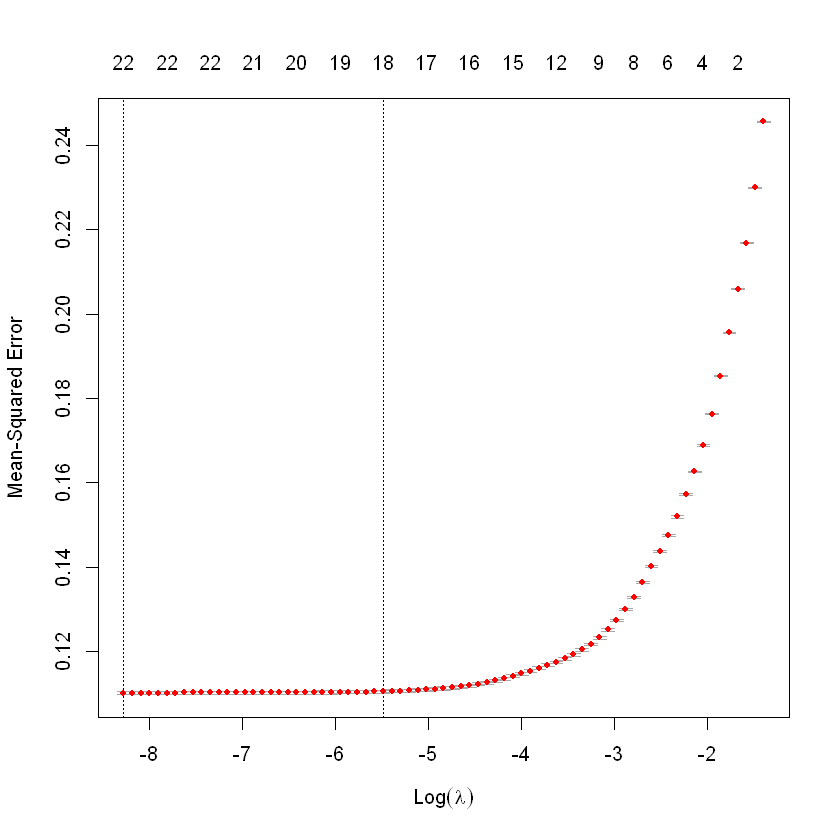

In [212]:
plot(cv_model)

In [213]:
best_model <- glmnet(x, y, alpha = 1, lambda = 0.01)

In [214]:
coef(best_model)

23 x 1 sparse Matrix of class "dgCMatrix"
                                             s0
(Intercept)                       -0.5836435628
Gender                             .           
Customer.Type                      0.2560841125
Age                                .           
Type.of.Travel                    -0.3484633903
Class                              0.1301034951
Flight.Distance                    .           
Inflight.wifi.service              0.0430015097
Departure.Arrival.time.convenient -0.0108481395
Ease.of.Online.booking            -0.0158535559
Gate.location                      .           
Food.and.drink                     .           
Online.boarding                    0.0774332084
Seat.comfort                       0.0039648097
Inflight.entertainment             0.0238179244
On.board.service                   0.0324293610
Leg.room.service                   0.0302358907
Baggage.handling                   0.0136558014
Checkin.service                    0.032999638

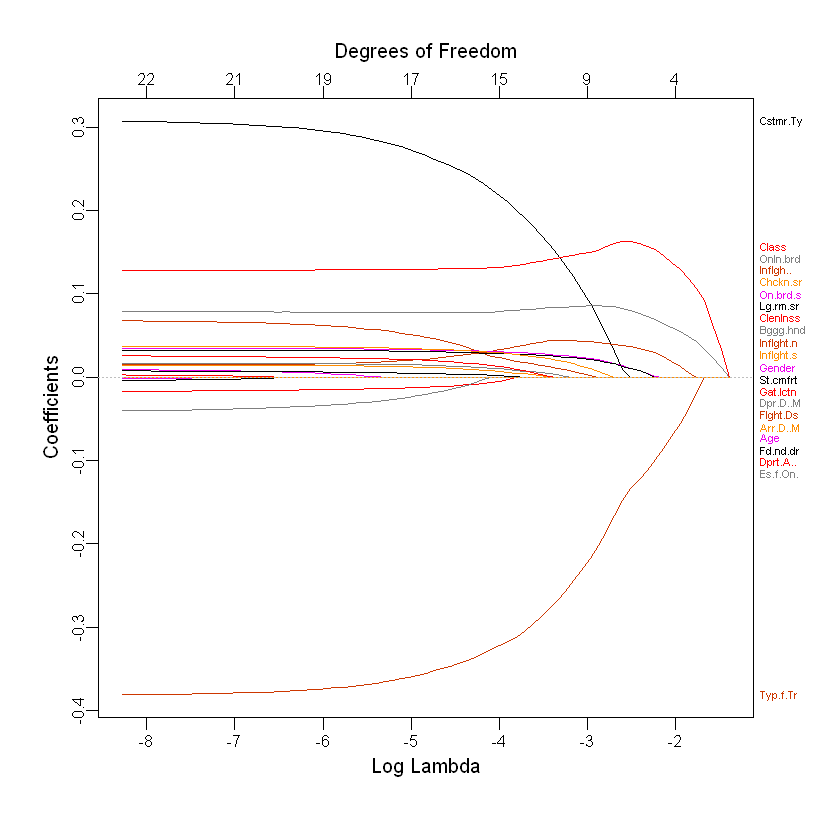

In [90]:
plot_glmnet(model, xvar = "lambda", label=TRUE)

In [91]:
#As per the plot we can say that ‘Gender, ‘Food and Drink’, ‘Age’, 
#‘Flight Distance’, ‘Departure.Delay.in.Minutes’ and ‘Gate Location’  as these columns’ 
#coefficient becomes 0 when lambda increases. Thus we excluse these columns.

In [92]:
df = subset(df, select = -c(Gender, Food.and.drink, Age, 
                            Flight.Distance, Departure.Delay.in.Minutes, Gate.location))

In [93]:
df

,Customer.Type,Type.of.Travel,Class,Inflight.wifi.service,Departure.Arrival.time.convenient,Ease.of.Online.booking,Online.boarding,Seat.comfort,Inflight.entertainment,On.board.service,Leg.room.service,Baggage.handling,Checkin.service,Inflight.service,Cleanliness,Arrival.Delay.in.Minutes,satisfaction
,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<fct>
1,1,1,0,3,4,3,3,5,5,4,3,4,4,5,5,18,neutral or dissatisfied
2,0,0,1,3,2,3,3,1,1,1,5,3,1,4,1,6,neutral or dissatisfied
3,1,0,1,2,2,2,5,5,5,4,3,4,4,4,5,0,satisfied
4,1,0,1,2,5,5,2,2,2,2,5,3,1,4,2,9,neutral or dissatisfied
5,1,0,1,3,3,3,5,5,3,3,4,4,3,3,3,0,satisfied
6,1,1,0,3,4,2,2,1,1,3,4,4,4,4,1,0,neutral or dissatisfied
7,1,1,0,2,4,2,2,2,2,3,3,4,3,5,2,23,neutral or dissatisfied
8,1,0,1,4,3,4,5,5,5,5,5,5,4,5,4,0,satisfied
9,1,0,1,1,2,2,3,3,1,1,2,1,4,1,2,0,neutral or dissatisfied


In [296]:
# Data Modeling

In [297]:
# Here we deploy machine learning models on the data

In [298]:
# Here we the split the data using sample.split(), with split ration of 80:20

In [158]:
set.seed(400)
split <- sample.split(df, SplitRatio = 0.8)

In [159]:
train = subset(df, split == TRUE)
test = subset(df, split == FALSE)

In [96]:
# RANDOM FOREST

In [97]:
# We create first model with default number of trees and variables, which will be 500 tress with 3 randomly chosen variables
# in each tree

In [145]:
model_1 = randomForest(satisfaction ~ Customer.Type + Type.of.Travel + Inflight.wifi.service +
                       Departure.Arrival.time.convenient + Online.boarding +
                       Seat.comfort + Inflight.entertainment + On.board.service + Leg.room.service
                       + Baggage.handling + Checkin.service 
                        + Inflight.service + Cleanliness + Arrival.Delay.in.Minutes,
                      data = train, importance = TRUE)

In [99]:
print(model_1)


Call:
 randomForest(formula = satisfaction ~ Customer.Type + Type.of.Travel +      Inflight.wifi.service + Departure.Arrival.time.convenient +      Online.boarding + Seat.comfort + Inflight.entertainment +      On.board.service + Leg.room.service + Baggage.handling +      Checkin.service + Inflight.service + Cleanliness + Arrival.Delay.in.Minutes,      data = train, importance = TRUE) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 3.92%
Confusion matrix:
                        neutral or dissatisfied satisfied class.error
neutral or dissatisfied                   54937      1133  0.02020688
satisfied                                  2756     40494  0.06372254


In [ ]:
# Further to fine-tune the model, we try different values for mtry, which will be numberof variables and compare the accuracy

In [216]:
a=c()
i=6
for (i in 4:6) {
  model_2 <- randomForest(satisfaction ~ Customer.Type + Type.of.Travel + Inflight.wifi.service +
                        Departure.Arrival.time.convenient + Online.boarding +
                        Seat.comfort + Inflight.entertainment + On.board.service + Leg.room.service
                        + Baggage.handling + Checkin.service + Ease.of.Online.booking
                         + Inflight.service + Cleanliness + Arrival.Delay.in.Minutes,
                        data = train,mtry = i,importance = TRUE)
   pred <- predict(model_2, test, type = "class")
   a[i-2] = mean(pred == test$satisfaction)
}


In [218]:
a

[1]        NA 0.9609293 0.9600458 0.9599476

In [ ]:
# Thus our baseline model with mtry = 3, has best accuracy, thus we move forward with it

In [227]:
pred_1 = predict(model_1, test, type = "class")
acc = mean(pred_1 == test$satisfaction)

In [149]:
conf_rf <- confusionMatrix(data = (pred_1),reference = (test$satisfaction), mode = "everything")
conf_rf 

Confusion Matrix and Statistics

                         Reference
Prediction                neutral or dissatisfied satisfied
  neutral or dissatisfied                   17056       849
  satisfied                                   326     12329
                                                 
               Accuracy : 0.9616                 
                 95% CI : (0.9593, 0.9637)       
    No Information Rate : 0.5688                 
    P-Value [Acc > NIR] : < 2.2e-16              
                                                 
                  Kappa : 0.9212                 
                                                 
 Mcnemar's Test P-Value : < 2.2e-16              
                                                 
            Sensitivity : 0.9812                 
            Specificity : 0.9356                 
         Pos Pred Value : 0.9526                 
         Neg Pred Value : 0.9742                 
              Precision : 0.9526                 
  

In [ ]:
# LOGISTIC REGRESSION

In [ ]:
# This is the baseline model with no-modification, we train the model named log_model_1 on the train data set.

In [106]:
log_model_1 = glm(satisfaction ~ Customer.Type + Type.of.Travel + Inflight.wifi.service +
                       Departure.Arrival.time.convenient + Online.boarding +
                       Seat.comfort + Inflight.entertainment + On.board.service + Leg.room.service
                       + Baggage.handling + Checkin.service
                        + Inflight.service + Cleanliness + Arrival.Delay.in.Minutes,
                       data = train, family = 'binomial')

In [107]:
summary(log_model_1)


Call:
glm(formula = satisfaction ~ Customer.Type + Type.of.Travel + 
    Inflight.wifi.service + Departure.Arrival.time.convenient + 
    Online.boarding + Seat.comfort + Inflight.entertainment + 
    On.board.service + Leg.room.service + Baggage.handling + 
    Checkin.service + Inflight.service + Cleanliness + Arrival.Delay.in.Minutes, 
    family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7134  -0.5054  -0.1664   0.3961   4.0542  

Coefficients:
                                    Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                       -8.9000051  0.0677303 -131.404   <2e-16 ***
Customer.Type                      2.1263597  0.0269932   78.774   <2e-16 ***
Type.of.Travel                    -3.1851062  0.0272889 -116.718   <2e-16 ***
Inflight.wifi.service              0.2812132  0.0094482   29.764   <2e-16 ***
Departure.Arrival.time.convenient -0.1685041  0.0071660  -23.514   <2e-16 ***
Online.boarding       

In [ ]:
# We predict the outcome on test set, and outcome is in the range 0 to 1

In [108]:
pred_log_1 = predict(log_model_1, test, type = 'response')

In [ ]:
# We set the threshold as 0.5 and everything less than that is neutral and more than that is encoded as satisfied

In [157]:
f_pred_log_1 = ifelse(pred_log_1<0.5,'neutral or dissatisfied','satisfied')

In [ ]:
# As our predictions are in numbers, we convert the test set-satisfaction column to 1 and 0, to compare and calculate accuracy

In [160]:
#y_test = ifelse(test$satisfaction == 'satisfied',1,0)
y_test = test$satisfaction
acc = mean(f_pred_log_1 == y_test)
acc

[1] 0.8708115

In [161]:
print(vif(log_model_1)) # Here we check for multicollinearity between the independent variables, and there is none.

                    Customer.Type                    Type.of.Travel 
                         1.308191                          1.331115 
            Inflight.wifi.service Departure.Arrival.time.convenient 
                         1.480372                          1.294348 
                  Online.boarding                      Seat.comfort 
                         1.369040                          1.983704 
           Inflight.entertainment                  On.board.service 
                         2.823227                          1.601250 
                 Leg.room.service                  Baggage.handling 
                         1.198797                          1.807484 
                  Checkin.service                  Inflight.service 
                         1.197348                          1.980110 
                      Cleanliness          Arrival.Delay.in.Minutes 
                         2.339156                          1.018448 


In [ ]:
# According to summary of model_1, the column Inflight.entertainment has least importance/effect in predicting the outcome
# thus we drop the column and train another model named log_model_2

In [162]:
log_model_2 = glm(satisfaction ~ Customer.Type + Type.of.Travel + Inflight.wifi.service +
                       Departure.Arrival.time.convenient + Online.boarding +
                       Seat.comfort + Inflight.entertainment + On.board.service + Leg.room.service
                       + Baggage.handling + Checkin.service
                         + Cleanliness + Arrival.Delay.in.Minutes,
                       data = train, family = 'binomial')

In [163]:
summary(log_model_2)


Call:
glm(formula = satisfaction ~ Customer.Type + Type.of.Travel + 
    Inflight.wifi.service + Departure.Arrival.time.convenient + 
    Online.boarding + Seat.comfort + Inflight.entertainment + 
    On.board.service + Leg.room.service + Baggage.handling + 
    Checkin.service + Cleanliness + Arrival.Delay.in.Minutes, 
    family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7105  -0.5065  -0.1670   0.3986   4.0660  

Coefficients:
                                    Estimate Std. Error  z value Pr(>|z|)    
(Intercept)                       -8.7184397  0.0658717 -132.355  < 2e-16 ***
Customer.Type                      2.0885610  0.0267456   78.090  < 2e-16 ***
Type.of.Travel                    -3.1524028  0.0270522 -116.530  < 2e-16 ***
Inflight.wifi.service              0.2796947  0.0094176   29.699  < 2e-16 ***
Departure.Arrival.time.convenient -0.1648779  0.0071432  -23.082  < 2e-16 ***
Online.boarding                    0.6185

In [164]:
pred_log_2 = predict(log_model_2, test, type = 'response')

In [ ]:
# we convert the numerical predicted values to their corresponding labels

In [165]:
f_pred_log_string = ifelse(pred_log_2<0.5,'neutral or dissatisfied','satisfied')

In [256]:
y_test = test$satisfaction
acc = mean(f_pred_log_string == y_test)
acc

[1] 0.8692736

In [ ]:
# There is slightly to almost no differene in accuracy, but the AIC increases thus we choose the baseline model, log_model_1

In [170]:
conf_log <- confusionMatrix(data = as.factor(f_pred_log_string),reference = as.factor(y_test),mode = "everything", positive = "satisfied")
conf_log

Confusion Matrix and Statistics

                         Reference
Prediction                neutral or dissatisfied satisfied
  neutral or dissatisfied                   15667      2280
  satisfied                                  1715     10898
                                         
               Accuracy : 0.8693         
                 95% CI : (0.8654, 0.873)
    No Information Rate : 0.5688         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.7321         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.8270         
            Specificity : 0.9013         
         Pos Pred Value : 0.8640         
         Neg Pred Value : 0.8730         
              Precision : 0.8640         
                 Recall : 0.8270         
                     F1 : 0.8451         
             Prevalence : 0.4312      

In [ ]:
# Final comparison

In [257]:
Model <- c("Logistic Regression", "Random Forest")
Accuracy <- c(0.8692,0.9791)
f1score <- c(0.8451,0.9817)
recall <- c(0.8297,0.9897)
specificity <-c(0.9013,0.9651)
precision <- c(0.8640,0.9738)
kappa <- c(0.7321,0.9573)

df_1 <- data.frame(Model, Accuracy , f1score, recall,specificity,precision, kappa)

(df_1)

Model,Accuracy,f1score,recall,specificity,precision,kappa
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Logistic Regression,0.8692,0.8451,0.8297,0.9013,0.8640,0.7321
Random Forest,0.9791,0.9817,0.9897,0.9651,0.9738,0.9573


In [ ]:
# AUC ROC for Random Forest

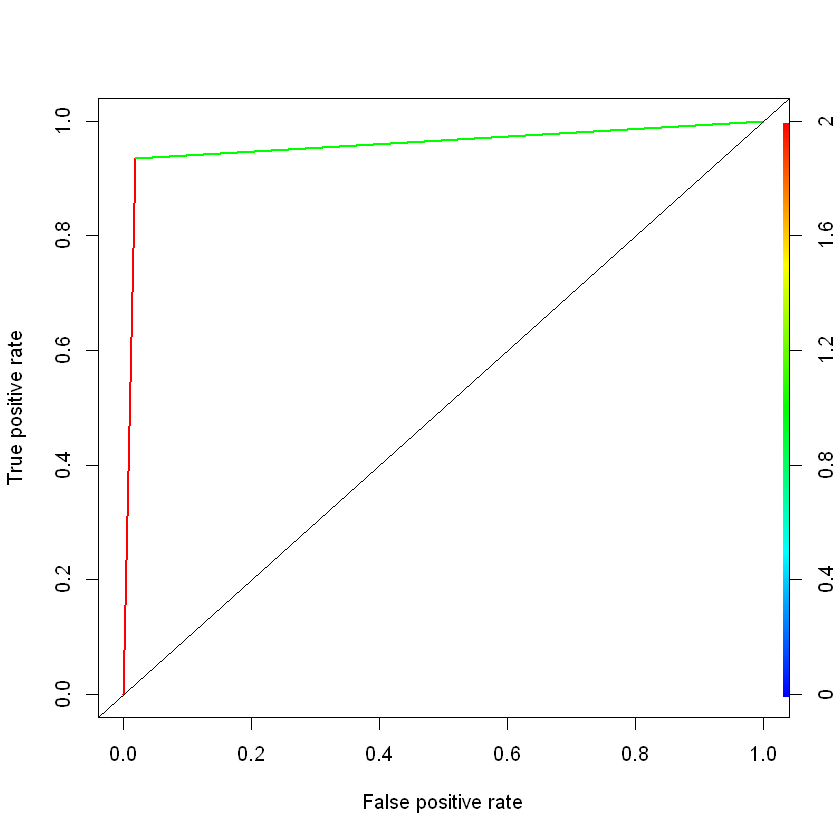

In [251]:
pred_0 = predict(model_1, test, type = "response")
pred_0 = ifelse(pred_0=='satisfied',1,0)
num_y = ifelse(test$satisfaction=='satisfied',1,0)
pred = prediction(pred_0, num_y)
roc = performance(pred,"tpr","fpr")
plot(roc, colorize = T, lwd = 2)
abline(a = 0, b = 1) 

In [ ]:
# AUC ROC for Logistic Regression 

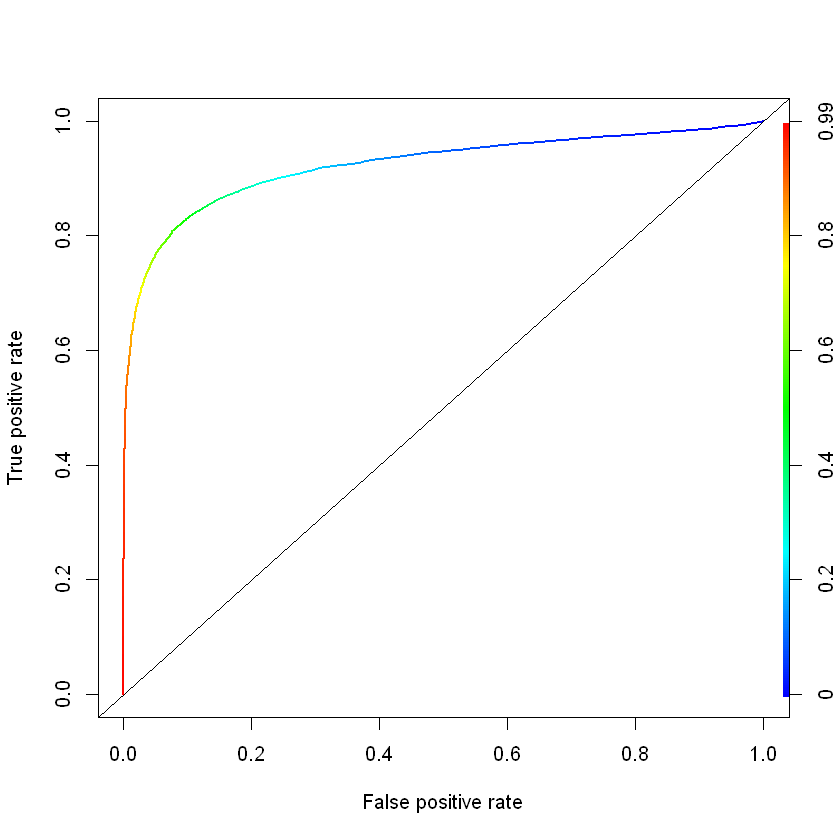

In [250]:
pred = prediction(pred_log_1, num_y)
roc = performance(pred,"tpr","fpr")
plot(roc, colorize = T, lwd = 2)
abline(a = 0, b = 1) 

In [ ]:
# confusion matrix for Random Forest

In [ ]:
# Looking at both the ROC curves, we can say that Random forest has better seperabality, with much precise predictions, than 
# logistic regression

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


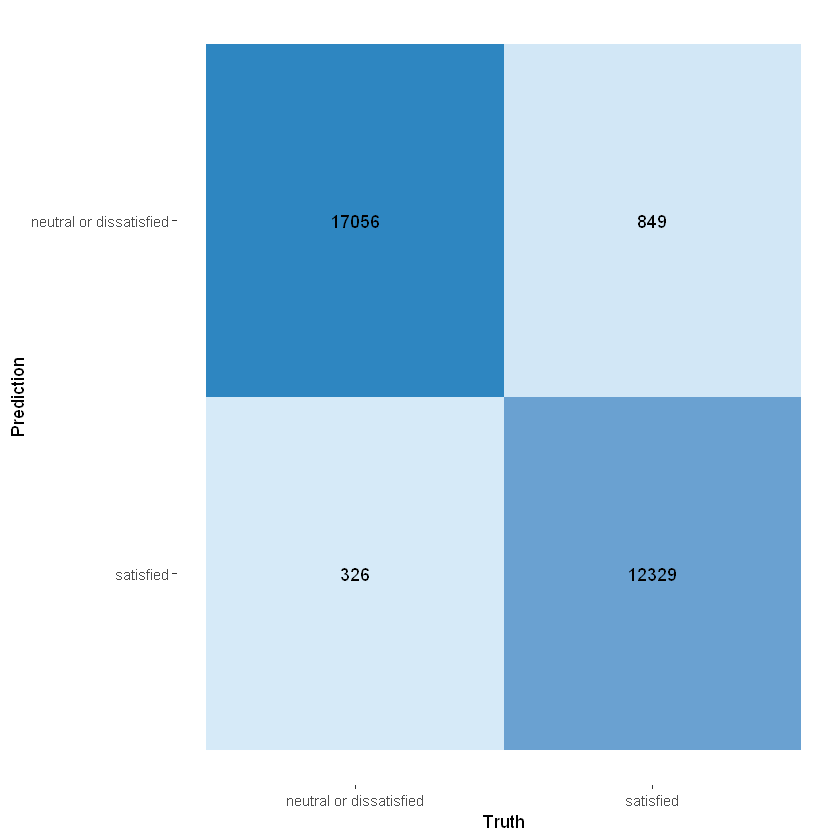

In [252]:
set.seed(123)
truth_predicted <- data.frame(
  obs = test$satisfaction,
  pred = pred_1
)
truth_predicted$obs <- as.factor(truth_predicted$obs)
truth_predicted$pred <- as.factor(truth_predicted$pred)
cm <- conf_mat(truth_predicted, obs, pred)

autoplot(cm, type = "heatmap") +
  scale_fill_gradient(low="#D6EAF8",high = "#2E86C1")

In [ ]:
# confusion matrix for Logistic Regression

In [171]:
set.seed(123)
truth_predicted <- data.frame(
  obs = y_test,
  pred = f_pred_log_string
)
truth_predicted$obs <- as.factor(truth_predicted$obs)
truth_predicted$pred <- as.factor(truth_predicted$pred)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


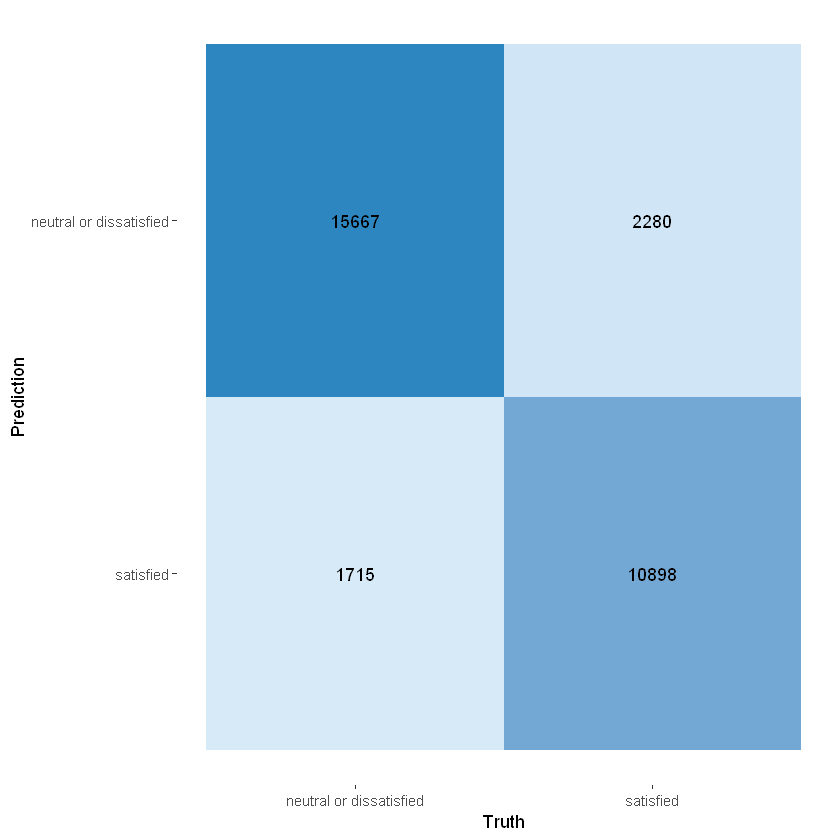

In [172]:
library(yardstick)
library(ggplot2)

# The confusion matrix from a single assessment set (i.e. fold)
cm <- conf_mat(truth_predicted, obs, pred)

autoplot(cm, type = "heatmap") +
  scale_fill_gradient(low="#D6EAF8",high = "#2E86C1")

In [ ]:
# Looking at the above metrics we can state that Random Forest is the ideal algorithm for the given problem statement,